In [31]:
%pylab inline

import pandas as pd
import pickle
import requests
import quandl
import seaborn as sns

plt.style.use('seaborn')
rcParams["axes.grid"] = True
rcParams["figure.figsize"] = (12,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
quandl.ApiConfig.api_key = open('keys/quandl.keys', 'r').read().split('\n')[0]

In [153]:
px = pd.read_csv('data/^STOXX50E.csv',index_col=0).Close
px.index = pd.to_datetime(px.index)

In [13]:
# Get dividend futures with expiries Dec2014 to Dec2028 from launch (2013-09-09) to present
div_futures = [f'FEXDZ{year+2014}' for year in range(15)]
divs = {}
for div in div_futures:
    divs[div] = quandl.get(f'EUREX/{div}', start_date='2013-09-09', end_date='2022-03-16').Settle 
divs = pd.DataFrame(divs)

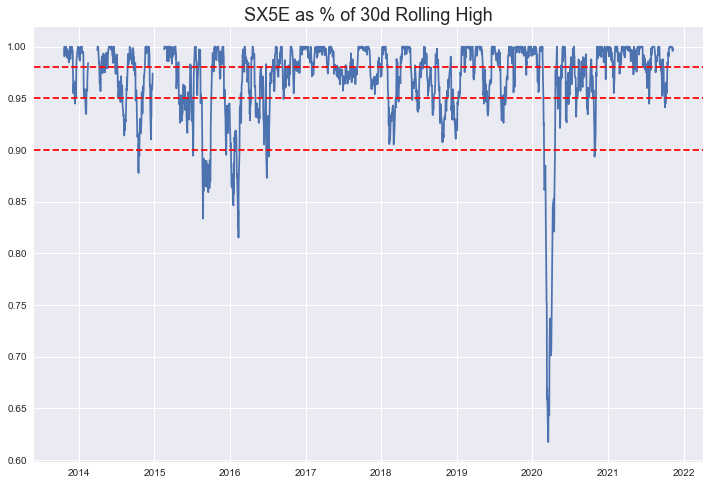

In [303]:
plot(px/px.rolling(30).max())
axhline(0.98, c='red', ls='--')
axhline(0.95, c='red', ls='--')
axhline(0.90, c='red', ls='--')
title('SX5E as % of 30d Rolling High', fontsize=18);

In [162]:
# Make index of price and dividend futures the same.
union = sorted(list(set(px.index).intersection(divs.index)))
px = px[union]
divs = divs.loc[union]

In [304]:
# Backtest strategy.
perf = pd.Series(dtype=float)
date = divs.index[0]
traded = False

# Holding period in days.
hold = 20
# Future expiry in yrs.
fut_yrs = 5
# Spot / recent high series.
ratio_of_high = px / px.rolling(30).max()

while date in divs.index:
    perf[date] = 0.0
    
    # If no current trade and drawdown target hit.
    if not traded and ratio_of_high[date] <= 0.98:
        contract_px = divs[f'FEXDZ{date.year + fut_yrs}'][date]
        #print(f'selling FEXDZ{date.year+fut_yrs} on {date:%Y-%m-%d} at {contract_px:.1f}')
        
        traded = True
        trade = -divs[f'FEXDZ{date.year + fut_yrs}'][date:].iloc[:hold+1].diff().fillna(0.0)
        for date in trade.index:
            # For each day in holding period, add perf of short future or end if hit rally target.
            if ratio_of_high[date] > 0.99:
                break
            perf[date] = trade[date]
        contract_px = divs[f'FEXDZ{date.year + fut_yrs}'][date]
        #print(f'covering FEXDZ{date.year+fut_yrs} on {date:%Y-%m-%d} at {contract_px:.1f}')
    # Do not trade again until within 1% of 30 day high.
    if ratio_of_high[date] > 0.99:
        traded = False
    if len(divs.loc[date:]) <= 1:
        break
    date = divs.loc[date:].index[1]

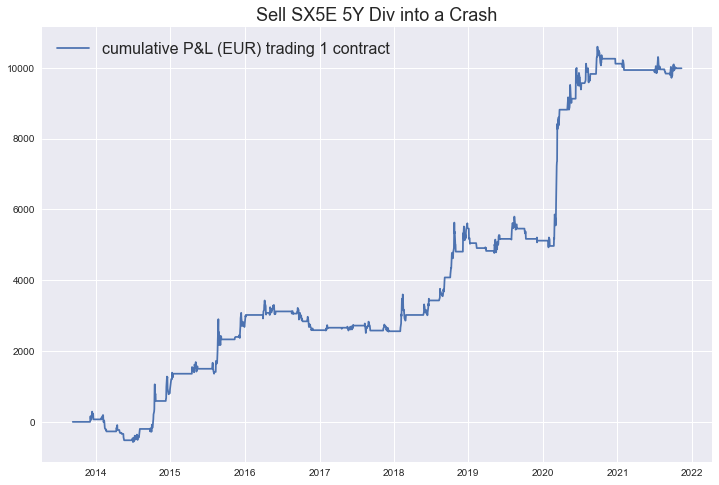

In [308]:
plot(100*perf.cumsum(), label='cumulative P&L (EUR) trading 1 contract')
legend(loc='upper left', fontsize=16)
title(f'Sell SX5E {fut_yrs}Y Div into a Crash', fontsize=18);

In [306]:
252 * perf.mean() / perf.std()

16.045129879399127

In [307]:
100 * perf.groupby(perf.index.year).sum()[1:]

2014     860.0
2015    1750.0
2016     -90.0
2017     -30.0
2018    2910.0
2019    -350.0
2020    5000.0
2021    -130.0
dtype: float64